In [2]:
pip install xgboost

In [3]:
#importing important libraries

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

In [4]:
# read training data (train_sample.csv)
train_sample = pd.read_csv('/content/train_sample.csv')

In [5]:
# Printing length of training data
len(train_sample)

100000

In [6]:
train_sample.memory_usage()

,0
Index,132
ip,800000
app,800000
device,800000
os,800000
channel,800000
click_time,800000
attributed_time,800000
is_attributed,800000


In [7]:
# Space used by the training data (in bytes)
memory_space = train_sample.memory_usage(deep=True).sum()

memory_space_mb = memory_space / (1024 ** 2)

print(f"Training data uses {memory_space_mb} MB.")


Training data uses 14.886970520019531 MB.


In [8]:
train_sample.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [9]:
train_sample=train_sample.drop(['attributed_time'], axis=1)

In [10]:
train_sample.head()

,ip,app,device,os,channel,click_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,0
1,105560,25,1,17,259,2017-11-07 13:40:27,0
2,101424,12,1,19,212,2017-11-07 18:05:24,0
3,94584,13,1,13,477,2017-11-07 04:58:08,0
4,68413,12,1,1,178,2017-11-09 09:00:09,0


# Exploring the data - Univariate Analysis

In [11]:
# look at non-null values, null values, number of entries etc.
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ip             100000 non-null  int64 
 1   app            100000 non-null  int64 
 2   device         100000 non-null  int64 
 3   os             100000 non-null  int64 
 4   channel        100000 non-null  int64 
 5   click_time     100000 non-null  object
 6   is_attributed  100000 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 5.3+ MB


No missing values

## Basic Exploratory Analysis

1 - Number of Unique values in each column

In [12]:
# Define a function to calculate the fraction of unique values in a column
def fraction_unique(x):
    return len(x.unique())

# Create a dictionary to store fractions of unique values for each column
number_unique_vals = {col: fraction_unique(train_sample[col]) for col in train_sample.columns}

# Print the dictionary of unique value fractions
print(number_unique_vals)


{'ip': 34857, 'app': 161, 'device': 100, 'os': 130, 'channel': 161, 'click_time': 80350, 'is_attributed': 2}


2 - Data type of each column

In [13]:
train_sample.dtypes

,0
ip,int64
app,int64
device,int64
os,int64
channel,int64
click_time,object
is_attributed,int64


Distribution of App

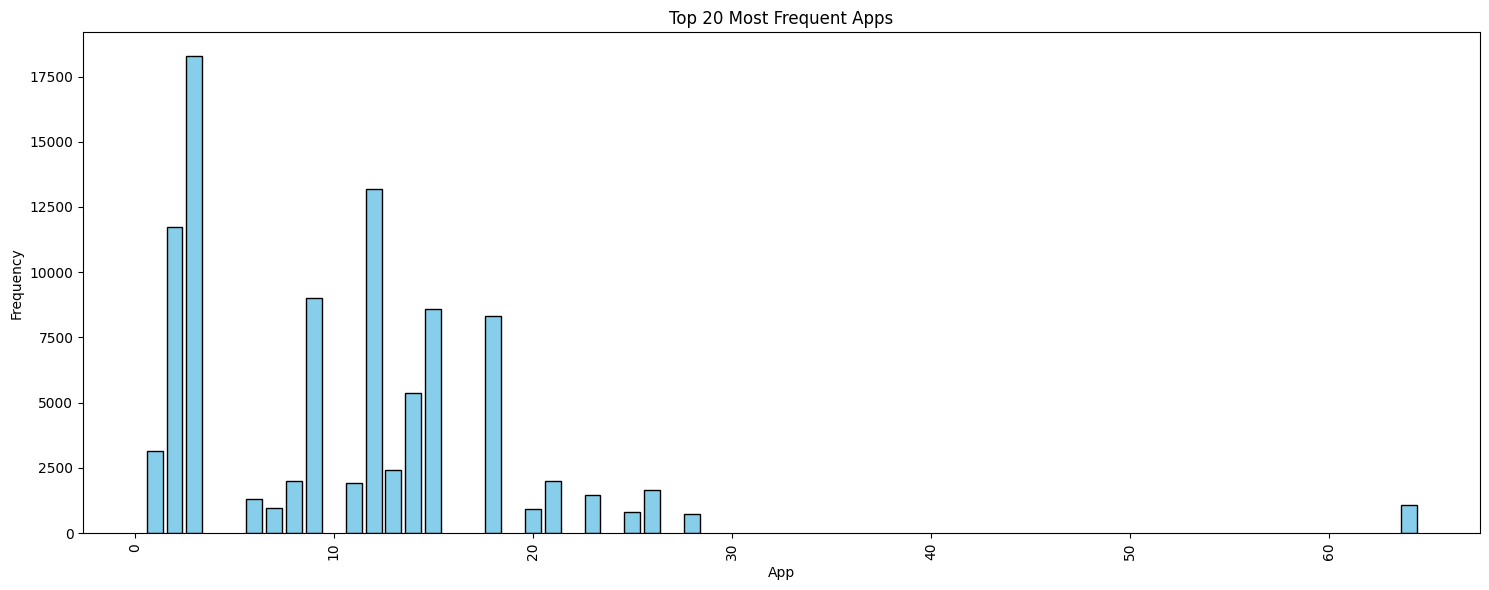

In [14]:
# Group by value and sort by frequency
top_apps = train_sample['app'].value_counts().head(20)  # Top 20 most frequent
plt.figure(figsize=(15, 6))
plt.bar(top_apps.index, top_apps.values, color='skyblue', edgecolor='black')

plt.xticks(rotation=90, fontsize=10)
plt.xlabel('App')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Apps')
plt.tight_layout()
plt.show()


Distribution of device

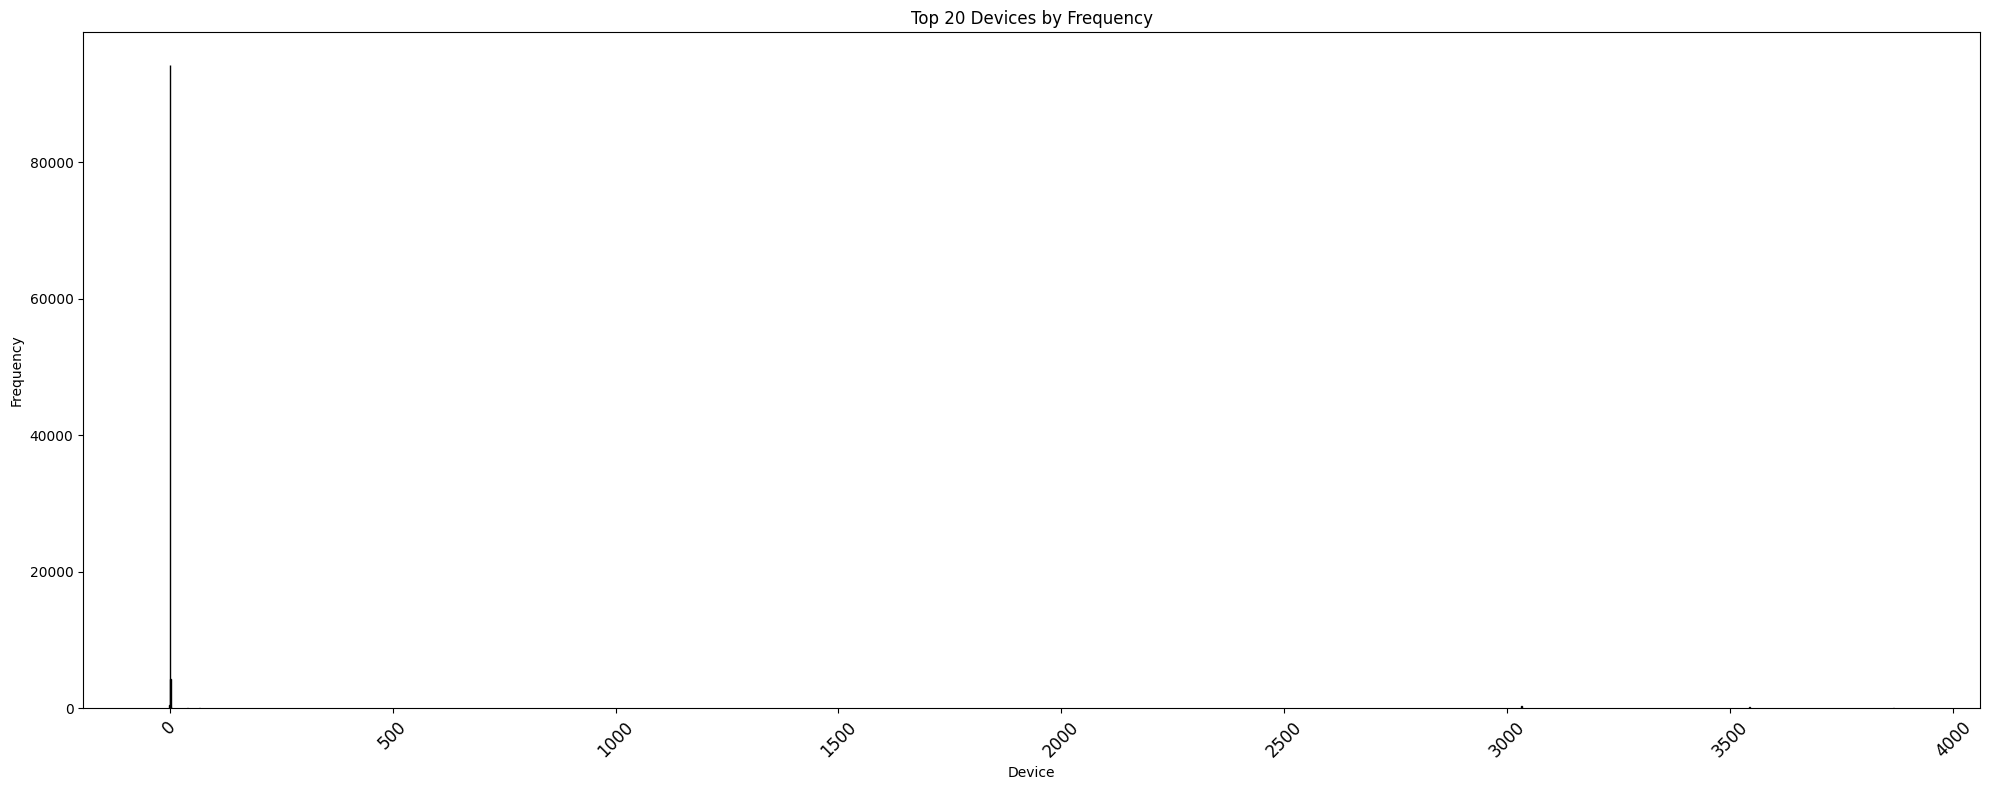

In [15]:
# Ensure 'device' is treated as categorical
train_sample['device'] = train_sample['device'].astype('category')

# Get the counts of each unique device and select the top 20
device_counts_top20 = train_sample['device'].value_counts().head(20)

# Create the bar plot
plt.figure(figsize=(20, 8))  # Adjust figure size for clarity
plt.bar(device_counts_top20.index, device_counts_top20.values, edgecolor='black', color='skyblue')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)

# Add labels and title
plt.xlabel('Device')
plt.ylabel('Frequency')
plt.title('Top 20 Devices by Frequency')
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


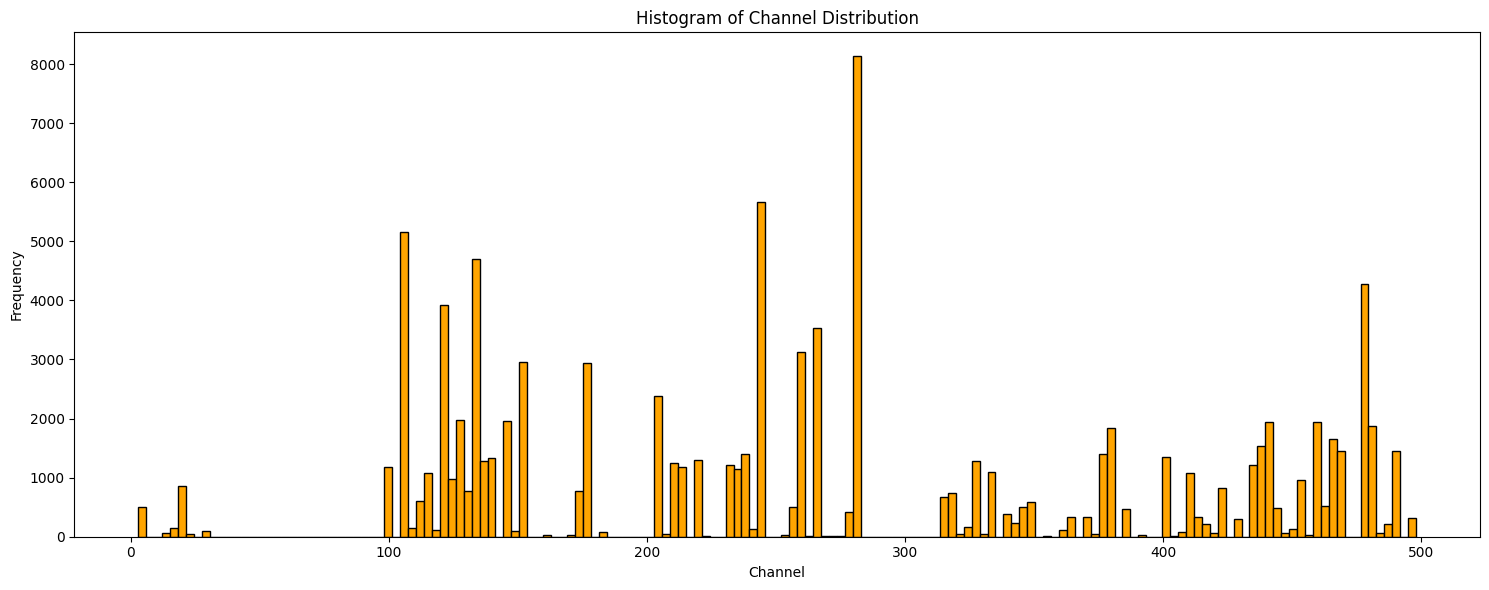

In [16]:
# distribution of 'channel'
plt.figure(figsize=(15, 6))  # Set figure size

# Create a histogram with the number of bins equal to the number of unique channels
plt.hist(train_sample['channel'], bins=len(train_sample['channel'].unique()), edgecolor='black', color='orange', align='mid')

# Add labels and title
plt.xlabel('Channel')
plt.ylabel('Frequency')
plt.title('Histogram of Channel Distribution')
plt.tight_layout()
plt.show()


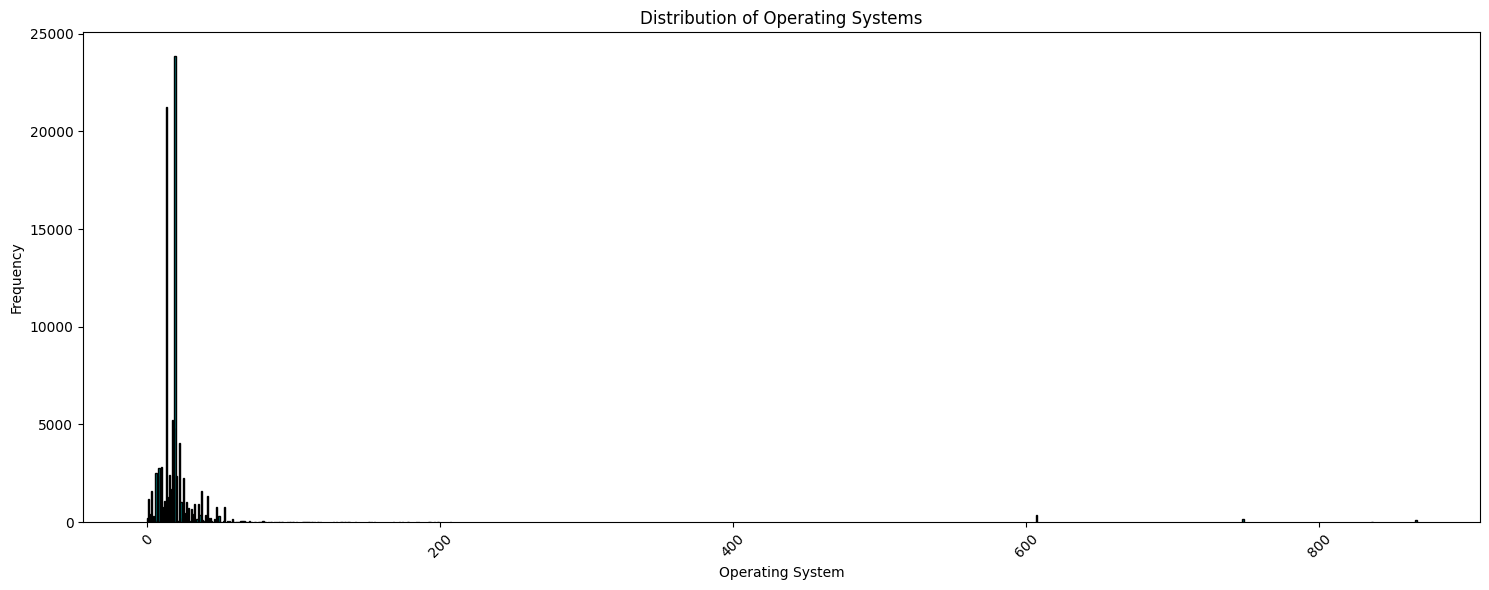

In [17]:
# distribution of 'os'
os_counts = train_sample['os'].value_counts()

# Create the bar plot
plt.figure(figsize=(15, 6))  # Set figure size
plt.bar(os_counts.index, os_counts.values, edgecolor='black', color='teal')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=10)

# Add labels and title
plt.xlabel('Operating System')
plt.ylabel('Frequency')
plt.title('Distribution of Operating Systems')
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


In [18]:
train_sample['is_attributed'].value_counts()

,count
is_attributed,
0,99773
1,227


## Exploring the Data- Segmented Univariate Analysis

In [19]:
# Group by 'app' and calculate both mean and count for 'is_attributed'
app_target = train_sample.groupby('app')['is_attributed'].agg(['mean', 'count']).reset_index()

# Rename the columns for clarity
app_target.columns = ['app', 'download_rate', 'count']

# Print the resulting DataFrame
print(app_target)


     app  download_rate  count
0      1       0.000000   3135
1      2       0.000000  11737
2      3       0.000219  18279
3      4       0.000000     58
4      5       0.074468    188
..   ...            ...    ...
156  486       0.000000      1
157  536       0.000000      1
158  538       0.000000      1
159  548       0.000000      1
160  551       0.000000      1

[161 rows x 3 columns]


In [20]:
# 1. Create the 'count' column based on app size and reset index
app_counts = train_sample.groupby('app').size().reset_index(name='count')

# 2. Filter count greater than the 80% quantile range
count_threshold = app_counts['count'].quantile(0.8)
frequent_apps = app_counts[app_counts['count'] > count_threshold]

# 3. Perform an inner join with train_sample on 'app'
frequent_apps = pd.merge(frequent_apps, train_sample, on='app', how='inner')

# 4. Print the head of frequent_apps
print(frequent_apps.head())


   app  count      ip device  os  channel           click_time  is_attributed
0    1   3135   17059      1  17      135  2017-11-09 01:17:58              0
1    1   3135   52432      1  13      115  2017-11-07 17:22:52              0
2    1   3135   89242      1  27      124  2017-11-07 09:37:21              0
3    1   3135  123994      1  19      101  2017-11-09 14:27:57              0
4    1   3135   34067      1  15      134  2017-11-07 15:06:06              0


<Figure size 1000x1000 with 0 Axes>

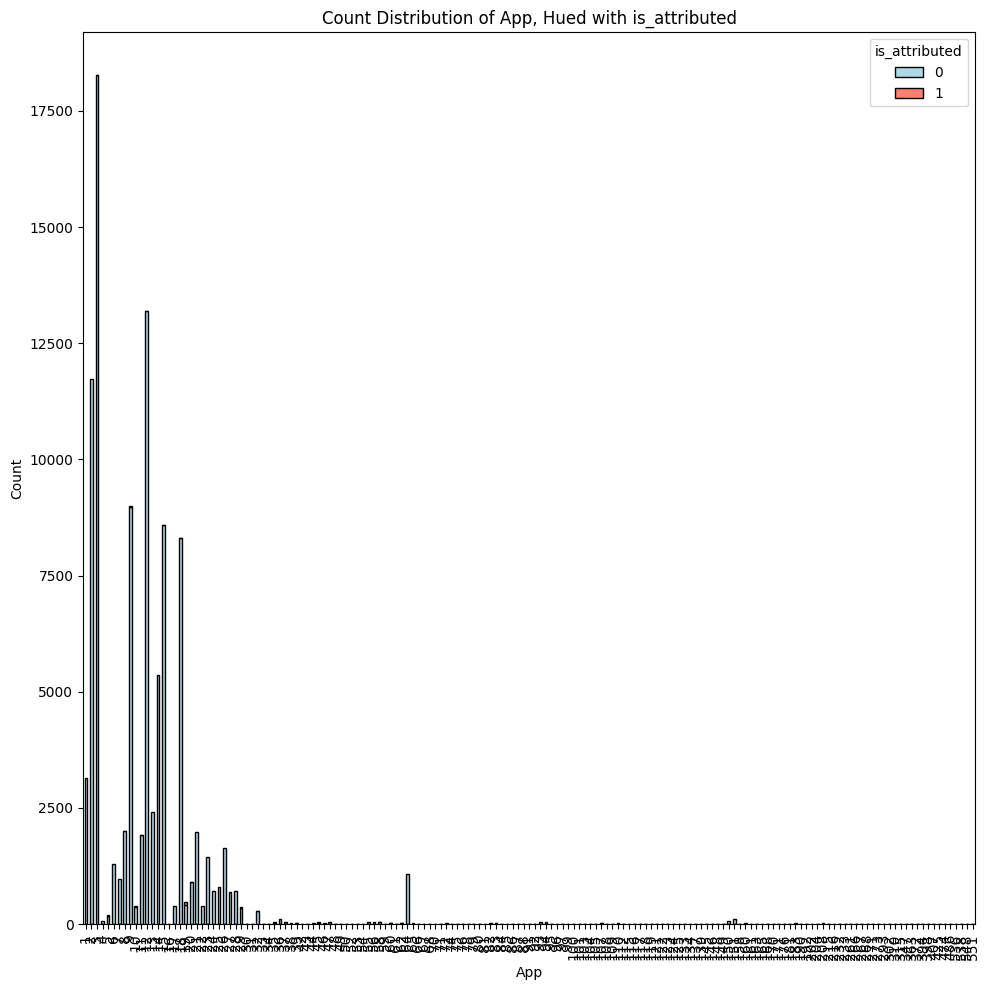

In [21]:
# Plot count distribution of 'app' hue with 'is_attributed'
plt.figure(figsize=(10, 10))  # Set the figure size

# Group by 'app' and 'is_attributed' to count occurrences
app_is_attributed_counts = train_sample.groupby(['app', 'is_attributed']).size().unstack(fill_value=0)

# Create the stacked bar plot
app_is_attributed_counts.plot(kind='bar', stacked=True, color=['lightblue', 'salmon'], edgecolor='black', figsize=(10, 10))

# Add labels and title
plt.xlabel('App')
plt.ylabel('Count')
plt.title('Count Distribution of App, Hued with is_attributed')
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


# Feature Engineering

## Date time Based features

In [22]:
import pandas as pd

def timeFeatures(df):
    # Ensure 'click_time' is in datetime format
    df['datetime'] = pd.to_datetime(df['click_time'])

    # Creating day_of_week variables (0 = Monday, 6 = Sunday)
    df['day_of_week'] = df['datetime'].dt.dayofweek

    # Creating day_of_year variables (1 to 365/366 depending on the year)
    df["day_of_year"] = df['datetime'].dt.dayofyear

    # Creating month variables (1 to 12)
    df["month"] = df['datetime'].dt.month

    # Creating hour variables (0 to 23)
    df["hour"] = df['datetime'].dt.hour

    # Return the modified dataframe
    return df


In [23]:
# Applying the timeFeatures function to train_sample
train_sample = timeFeatures(train_sample)

# Dropping the 'click_time' and 'datetime' columns
train_sample = train_sample.drop(columns=['click_time', 'datetime'])

# Print the first few rows of train_sample
print(train_sample.head())


       ip  app device  os  channel  is_attributed  day_of_week  day_of_year  \
0   87540   12      1  13      497              0            1          311   
1  105560   25      1  17      259              0            1          311   
2  101424   12      1  19      212              0            1          311   
3   94584   13      1  13      477              0            1          311   
4   68413   12      1   1      178              0            3          313   

   month  hour  
0     11     9  
1     11    13  
2     11    18  
3     11     4  
4     11     9  


In [24]:
train_sample['device'].astype('int')

,device
0,1
1,1
2,1
3,1
4,1
...,...
99995,1
99996,1
99997,1
99998,1


In [25]:
# Print the data types of all variables in train_sample
print(train_sample.dtypes)


ip                  int64
app                 int64
device           category
os                  int64
channel             int64
is_attributed       int64
day_of_week         int32
day_of_year         int32
month               int32
hour                int32
dtype: object


In [26]:
# Create a column 'ip_count' with the count of clicks for each unique IP address
ip_count = train_sample.groupby('ip').size().reset_index(name='ip_count')

# Print the head of the ip_count DataFrame
print(ip_count.head())


   ip  ip_count
0   9         1
1  10         3
2  19         1
3  20         4
4  25         1


In [27]:
def grouped_features(df):
    # ip_count: Count of clicks for each IP address
    ip_count = df.groupby('ip').size().reset_index(name='ip_count')

    # ip_day_hour: Count of clicks for each IP per day_of_week and hour
    ip_day_hour = df.groupby(['ip', 'day_of_week', 'hour']).size().reset_index(name='ip_day_hour')

    # ip_hour_channel: Count of clicks for each IP per hour and channel
    ip_hour_channel = df.groupby(['ip', 'hour', 'channel']).size().reset_index(name='ip_hour_channel')

    # ip_hour_os: Count of clicks for each IP per hour and OS
    ip_hour_os = df.groupby(['ip', 'hour', 'os']).size().reset_index(name='ip_hour_os')

    # ip_hour_app: Count of clicks for each IP per hour and app
    ip_hour_app = df.groupby(['ip', 'hour', 'app']).size().reset_index(name='ip_hour_app')

    # ip_hour_device: Count of clicks for each IP per hour and device
    ip_hour_device = df.groupby(['ip', 'hour', 'device']).size().reset_index(name='ip_hour_device')

    # Merge the new aggregated features with the DataFrame
    # Merge ip_count
    df = pd.merge(df, ip_count, on='ip', how='left')
    del ip_count  # Delete ip_count to save memory

    # Merge ip_day_hour
    df = pd.merge(df, ip_day_hour, on=['ip', 'day_of_week', 'hour'], how='left')
    del ip_day_hour  # Delete ip_day_hour to save memory

    # Merge ip_hour_channel
    df = pd.merge(df, ip_hour_channel, on=['ip', 'hour', 'channel'], how='left')
    del ip_hour_channel  # Delete ip_hour_channel to save memory

    # Merge ip_hour_os
    df = pd.merge(df, ip_hour_os, on=['ip', 'hour', 'os'], how='left')
    del ip_hour_os  # Delete ip_hour_os to save memory

    # Merge ip_hour_app
    df = pd.merge(df, ip_hour_app, on=['ip', 'hour', 'app'], how='left')
    del ip_hour_app  # Delete ip_hour_app to save memory

    # Merge ip_hour_device
    df = pd.merge(df, ip_hour_device, on=['ip', 'hour', 'device'], how='left')
    del ip_hour_device  # Delete ip_hour_device to save memory

    # Return the modified DataFrame
    return df


In [28]:
# Apply the grouped_features() function to train_sample
train_sample = grouped_features(train_sample)


In [29]:
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,87540,12,1,13,497,0,1,311,11,9,8,1,1,1,1,1
1,105560,25,1,17,259,0,1,311,11,13,149,4,1,1,1,8
2,101424,12,1,19,212,0,1,311,11,18,2,1,1,1,1,1
3,94584,13,1,13,477,0,1,311,11,4,3,1,1,1,1,1
4,68413,12,1,1,178,0,3,313,11,9,4,1,1,1,1,1


# Modelling

In [30]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target variable (y)
X = train_sample.drop(columns=['is_attributed'])  # Drop the target column from the dataset
y = train_sample['is_attributed']  # Target variable

# Split data into train and test/validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)







X_train shape: (80000, 15)
y_train shape: (80000,)
X_test shape: (20000, 15)
y_test shape: (20000,)


## Adaboost

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Instantiate DecisionTreeClassifier with max_depth=2 and random_state=1
tree = DecisionTreeClassifier(max_depth=2, random_state=1)

# Instantiate AdaBoostClassifier with the tree as the base estimator
adaboost_model_1 = AdaBoostClassifier(
    estimator=tree,        # Use the decision tree as the base estimator
    n_estimators=600,           # Maximum 600 weak learners
    learning_rate=1.5,          # Shrinkage parameter
    algorithm="SAMME",          # Use SAMME algorithm
    random_state=1              # Random seed for reproducibility
)


In [32]:
# Fit the AdaBoost model with the training dataset
adaboost_model_1.fit(X_train, y_train)

# Confirm training completion
print("Model training completed.")


Model training completed.


In [33]:
# prediction probabilities on X_test
predictions = adaboost_model_1.predict_proba(X_test)

# the top 10 prediction probabilities
print(predictions[:10])


[[0.57001067 0.42998933]
 [0.56307654 0.43692346]
 [0.59604766 0.40395234]
 [0.55709624 0.44290376]
 [0.55158406 0.44841594]
 [0.56314921 0.43685079]
 [0.56309423 0.43690577]
 [0.56943985 0.43056015]
 [0.56758987 0.43241013]
 [0.54035568 0.45964432]]


In [34]:
from sklearn.metrics import roc_auc_score

# Get probabilities for the positive class (class 1)
positive_class_probs = predictions[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_test, positive_class_probs)

# Print the AUC score
print("AUC Score:", auc_score)


AUC Score: 0.9530610540382527


## Adaboost-hyperparameter tunning

In [35]:
# parameter grid with base_estimator__max_depth as [2,5] and n_estimators as [200, 400, 600]
param_grid = {
    'estimator__max_depth': [2, 5],  # Maximum depth of the decision tree
    'n_estimators': [200, 400, 600]       # Number of weak learners
}


In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# DecisionTreeClassifier as base estimator with random_state=1
tree = DecisionTreeClassifier(random_state=1)

# AdaBoost with the tree as base estimator, learning rate=0.6, and algorithm="SAMME"
ABC = AdaBoostClassifier(
    estimator=tree,        # Use the decision tree as the base estimator
    n_estimators=50,            # Number of estimators (you can adjust this)
    learning_rate=0.6,          # Learning rate
    algorithm="SAMME",          # Use the SAMME algorithm
    random_state=1              # Random seed for reproducibility
)


### Run Grid Seaarch CV

In [37]:
from sklearn.model_selection import GridSearchCV

# Set the number of folds for cross-validation
folds = 3

# Run GridSearchCV with ABC, folds, param_grid, scoring as roc_auc, return_train_score=True, and verbose=1
grid_search_ABC = GridSearchCV(
    estimator=ABC,              # AdaBoost model
    param_grid=param_grid,      # Parameter grid
    cv=folds,                   # Number of cross-validation folds
    scoring='roc_auc',          # Scoring metric for evaluation
    return_train_score=True,    # Return training scores for each fold
    verbose=1                    # Show detailed output
)




In [38]:
# Ensure X_train and y_train are numpy arrays or DataFrames
X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
y_train = y_train.values if isinstance(y_train, pd.Series) else y_train



In [39]:
# Run the grid search
grid_search_ABC.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search_ABC.best_params_)
print("Best AUC score found: ", grid_search_ABC.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters found:  {'estimator__max_depth': 2, 'n_estimators': 200}
Best AUC score found:  0.9555167000828524


In [40]:
# Access the cross-validation results
cv_results = grid_search_ABC.cv_results_


In [41]:
cv_results

{'mean_fit_time': array([14.9379971 , 29.08209348, 44.11620768, 32.30051517, 65.72375544,
        97.69850628]),
 'std_fit_time': array([0.67634407, 0.32752922, 0.87219555, 0.6120456 , 3.30799265,
        0.32754105]),
 'mean_score_time': array([0.44101501, 0.86271501, 1.20890832, 0.4490633 , 1.05616442,
        1.67481796]),
 'std_score_time': array([0.12080851, 0.24655856, 0.29858575, 0.00485233, 0.25819948,
        0.31057597]),
 'param_estimator__max_depth': masked_array(data=[2, 2, 2, 5, 5, 5],
              mask=[False, False, False, False, False, False],
        fill_value=999999),
 'param_n_estimators': masked_array(data=[200, 400, 600, 200, 400, 600],
              mask=[False, False, False, False, False, False],
        fill_value=999999),
 'params': [{'estimator__max_depth': 2, 'n_estimators': 200},
  {'estimator__max_depth': 2, 'n_estimators': 400},
  {'estimator__max_depth': 2, 'n_estimators': 600},
  {'estimator__max_depth': 5, 'n_estimators': 200},
  {'estimator__max_dep

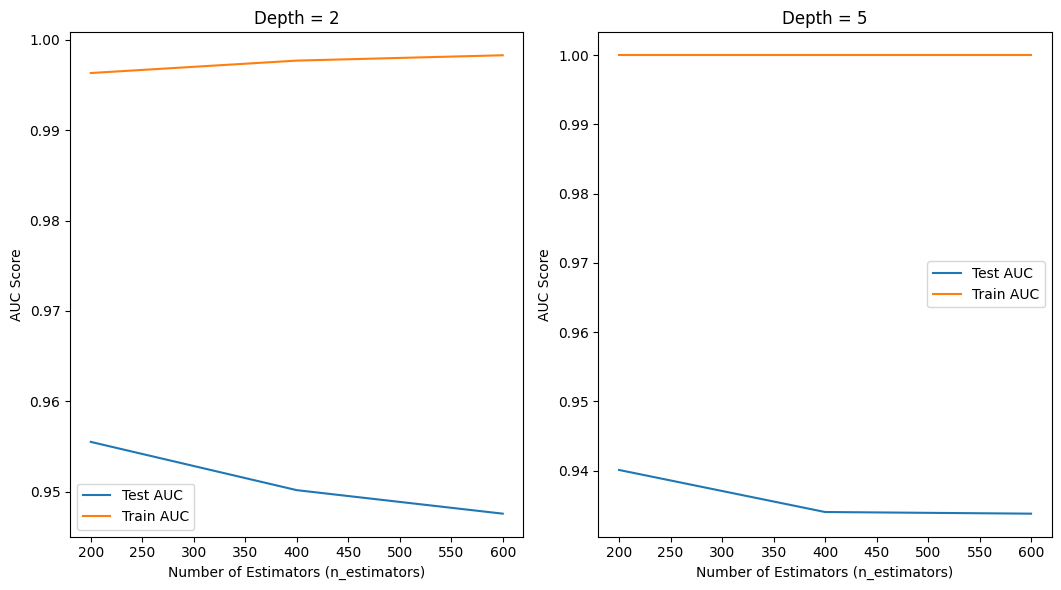

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract cv_results
cv_results = grid_search_ABC.cv_results_

# Plotting AUC with hyperparameter combinations
plt.figure(figsize=(16, 6))

# Loop over the max_depth values
for n, depth in enumerate(param_grid['estimator__max_depth']):

    # Filter results for each max_depth
    depth_df = pd.DataFrame(cv_results)
    depth_df = depth_df[depth_df['param_estimator__max_depth'] == depth]

    # Plot AUC scores for mean_test_score and mean_train_score
    plt.subplot(1, 3, n+1)
    plt.plot(depth_df['param_n_estimators'], depth_df['mean_test_score'], label='Test AUC')
    plt.plot(depth_df['param_n_estimators'], depth_df['mean_train_score'], label='Train AUC')

    # Add labels and title
    plt.xlabel('Number of Estimators (n_estimators)')
    plt.ylabel('AUC Score')
    plt.title(f'Depth = {depth}')
    plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [43]:
# DecisionTreeClassifier  as base estimator with max_depth as 2 and random_state as 1
# DecisionTreeClassifier as base estimator with max_depth=2 and random_state=1
tree = DecisionTreeClassifier(max_depth=2, random_state=1)

# AdaBoost with the tree as base estimator, learning rate=0.6, n_estimators=200
ABC = AdaBoostClassifier(
    estimator=tree,         # Use the decision tree as the base estimator
    n_estimators=200,            # Number of weak learners (decision trees)
    learning_rate=0.6,           # Learning rate for the AdaBoost
    random_state=1               # Random state for reproducibility
)

# Fit the AdaBoost model with the training data
ABC.fit(X_train, y_train)



AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    random_state=1),
                   learning_rate=0.6, n_estimators=200, random_state=1)

In [44]:
# Predict probabilities on test data
predictions = ABC.predict_proba(X_test)

# Print the top 10 prediction probabilities for the positive class (class 1)
# Assuming class 1 is the positive class (binary classification)
print(predictions[:10, 1])


[0.41541013 0.37976186 0.36652649 0.25203711 0.46912779 0.34816921
 0.4506764  0.32448129 0.38986003 0.44349247]


In [45]:
# Calculate the ROC AUC score for the positive class (class 1)
roc_auc = roc_auc_score(y_test, predictions[:, 1])

# Print the ROC AUC score
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.8845892146217879


We have improved the model and adaboost gave us 96% of roc_auc coverage, which is a kind of good coverage

# Gradient Boosting Intuition

Boosting is a method of converting weak learners into strong learners. In boosting, each new tree is a fit on a modified version of the original data set.

Let's now try the gradient boosting classifier. We'll experiment with two main hyperparameters now - learning_rate (shrinkage) and subsample.

By adjusting the learning rate to less than 1, we can regularize the model. A model with higher learning_rate learns fast, but is prone to overfitting; one with a lower learning rate learns slowly, but avoids overfitting.

Also, there's a trade-off between learning_rate and n_estimators - the higher the learning rate, the lesser trees the model needs (and thus we usually tune only one of them).

In [46]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.2, 0.6, 0.9],  # Learning rates to explore
    'subsample': [0.3, 0.6, 0.9]       # Subsample values to explore
}



In [47]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting Classifier with max_depth=2, n_estimators=200, and random_state=1
GBC = GradientBoostingClassifier(
    max_depth=2,           # Maximum depth of individual estimators
    n_estimators=200,      # Number of boosting stages
    random_state=1         # Random state for reproducibility
)

# Print the Gradient Boosting Classifier to verify
print(GBC)

GradientBoostingClassifier(max_depth=2, n_estimators=200, random_state=1)


In [48]:
from sklearn.model_selection import GridSearchCV

# Define CV folds
folds = 3

# Instantiate GridSearchCV
grid_search_GBC = GridSearchCV(
    estimator=GBC,              # Gradient Boosting Classifier as the base estimator
    param_grid=param_grid,      # Parameter grid for hyperparameter tuning
    scoring='roc_auc',          # Scoring metric
    cv=folds,                   # Number of cross-validation folds
    return_train_score=True,    # Return training scores
    verbose=1                   # Display progress
)

# Fit GridSearchCV on the training data
grid_search_GBC.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search_GBC.best_params_)
print("Best ROC AUC Score:", grid_search_GBC.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters: {'learning_rate': 0.2, 'subsample': 0.9}
Best ROC AUC Score: 0.8286725815574695


In [49]:
# Extract cross-validation results into a DataFrame
cv_results = pd.DataFrame(grid_search_GBC.cv_results_)

# Print the first few rows of the results
cv_results.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,5.848844,0.519157,0.045873,0.013604,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.894474,0.820745,0.701982,0.805734,0.079298,2,0.911744,0.890071,0.746724,0.849513,0.073219
1,9.835385,0.568637,0.038184,0.003066,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.768198,0.933910,0.694824,0.798978,0.100004,3,0.739228,0.960480,0.717242,0.805650,0.109849
2,13.062580,0.041292,0.038378,0.000200,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.854797,0.818405,0.812816,0.828673,0.018613,1,0.894499,0.822440,0.756938,0.824625,0.056180
3,5.925791,0.337313,0.059018,0.015527,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.559689,0.136393,0.683106,0.459730,0.234119,8,0.466504,0.149746,0.674489,0.430246,0.215754
4,10.016956,0.130551,0.045059,0.013041,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.489911,0.672125,0.420938,0.527658,0.105963,5,0.452556,0.699505,0.406978,0.519679,0.128510


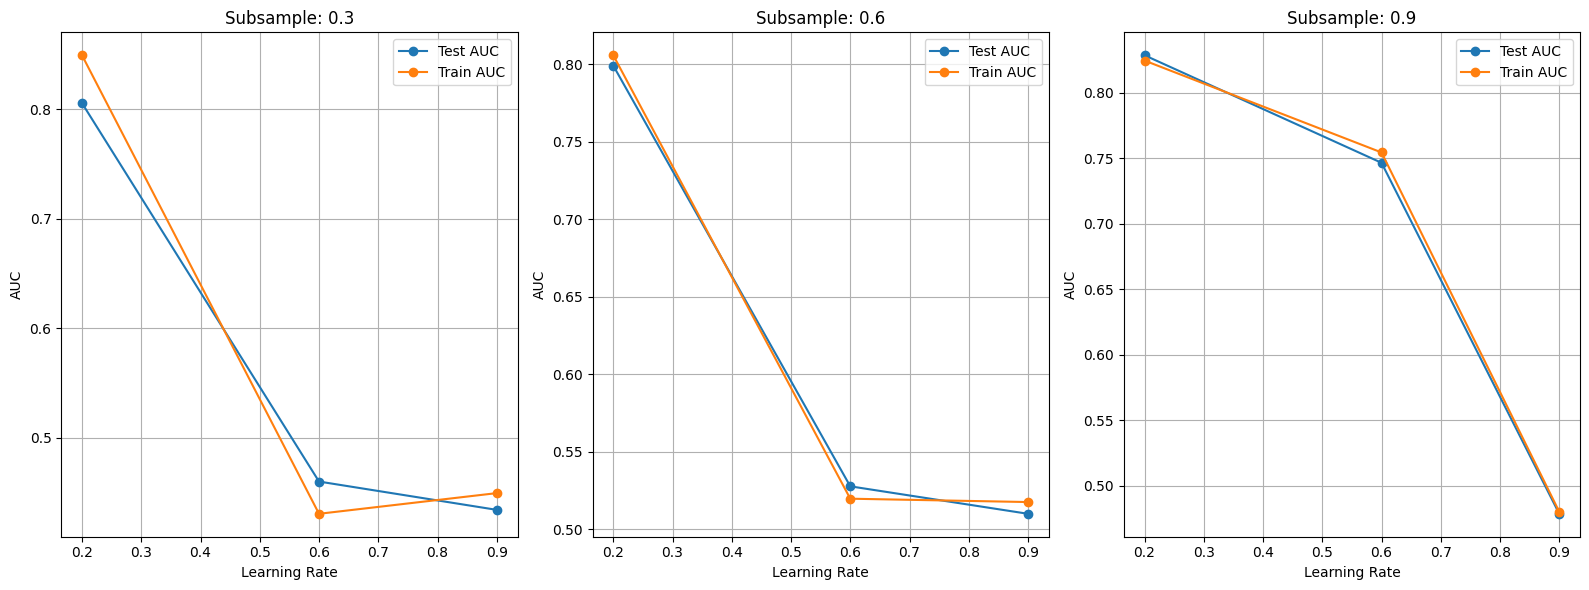

In [50]:
# Plotting AUC with hyperparameter combinations (subsample)
plt.figure(figsize=(16, 6))

# Iterate through each subsample value in the parameter grid
for n, subsample in enumerate(param_grid['subsample']):
    # Subset the CV results for the current subsample value
    df = cv_results[cv_results['param_subsample'] == subsample]

    # Create a subplot for each subsample value
    plt.subplot(1, len(param_grid['subsample']), n + 1)

    # Plot mean test and train scores against learning rate
    plt.plot(df["param_learning_rate"], df["mean_test_score"], label="Test AUC", marker='o')
    plt.plot(df["param_learning_rate"], df["mean_train_score"], label="Train AUC", marker='o')

    # Set titles and labels
    plt.title(f'Subsample: {subsample}', fontsize=12)
    plt.xlabel('Learning Rate', fontsize=10)
    plt.ylabel('AUC', fontsize=10)
    plt.legend()
    plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


It is clear from the plot above that the model with a lower subsample ratio performs better, while those with higher subsamples tend to overfit.

Also, a lower learning rate results in less overfitting.

In [51]:
# Fit the Gradient Boosting Classifier on the training data
GBC.fit(X_train, y_train)

# Predict probabilities for the test data
predictions = GBC.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (1)

# Print the top 10 prediction probabilities
print("Top 10 Prediction Probabilities:")
print(predictions[:10])


Top 10 Prediction Probabilities:
[0.00025444 0.0002638  0.00040811 0.0001857  0.00059318 0.00013185
 0.00022946 0.00019623 0.00013995 0.00068792]


In [52]:
from sklearn.metrics import roc_auc_score

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, predictions)

# Print the ROC AUC score
print(f"ROC AUC Score: {roc_auc}")


ROC AUC Score: 0.9615083938862441


# XGBoost

XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. In prediction problems involving unstructured data (images, text, etc.) artificial neural networks tend to outperform all other algorithms or frameworks. However, when it comes to small-to-medium structured/tabular data, decision tree based algorithms are considered best-in-class right now

In [53]:
!pip install scikit-learn==1.5.0 # Downgrade scikit-learn
!pip install xgboost==1.7.6 #

In [54]:
from xgboost import XGBClassifier

# Instantiate the XGBClassifier with default hyperparameters and random_state=1
model = XGBClassifier(random_state=1)

# Fit the model on the training data
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [66]:
 # Convert 'device' column to numerical representation before prediction
X_test['device'] = X_test['device'].cat.codes

# Now you can predict
y_pred = model.predict_proba(X_test)[:, 1]

# Print the top 10 predicted probabilities
print("Top 10 predicted probabilities:", y_pred[:10])

Top 10 predicted probabilities: [9.9423069e-06 1.1759036e-05 1.1221927e-06 6.7219935e-06 3.8832368e-05
 1.0031815e-06 1.4119561e-05 3.5650271e-06 1.5750743e-04 2.0083367e-04]


In [67]:
# Evaluate predictions using roc_auc_score
roc = roc_auc_score(y_test, y_pred)

# Print AUC
print("AUC Score:", roc)


AUC Score: 0.967747431721373


In [68]:
# Creating a KFold object with 3 splits
folds = KFold(n_splits=3, shuffle=True, random_state=1)

# Specifying the range of hyperparameters
param_grid = {
    "learning_rate": [0.2, 0.6],
    "subsample": [0.3, 0.6, 0.9]
}

# Specifying the model with max_depth=2 and n_estimators=200
xgb_model = XGBClassifier(max_depth=2, n_estimators=200, random_state=1, use_label_encoder=False)

# Setting up GridSearchCV
model_cv = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=folds,
    return_train_score=True,
    verbose=1
)


In [69]:
# Fit the model_cv on the training data
model_cv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     inte...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=1, ...),
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [70]:
# Get the cross-validation results as a DataFrame
cv_results = pd.DataFrame(model_cv.cv_results_)

cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,5.563433,1.075159,0.054681,0.006788,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.937817,0.986278,0.952780,0.958958,0.020261,5,0.994538,0.984926,0.992698,0.990721,0.004166
1,5.626988,1.103567,0.052199,0.002096,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.944611,0.990503,0.944646,0.959920,0.021625,4,0.993586,0.989663,0.991537,0.991595,0.001602
2,5.195781,1.113222,0.052294,0.003227,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.949577,0.992766,0.943283,0.961875,0.021994,1,0.993817,0.989999,0.991645,0.991820,0.001563
3,5.126039,1.018140,0.050168,0.000137,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.909826,0.975618,0.946131,0.943858,0.026907,6,0.995146,0.993939,0.993894,0.994327,0.000580
4,6.705629,1.306534,0.050514,0.000695,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.953423,0.989558,0.941849,0.961610,0.020319,3,0.998621,0.998522,0.998354,0.998499,0.000110


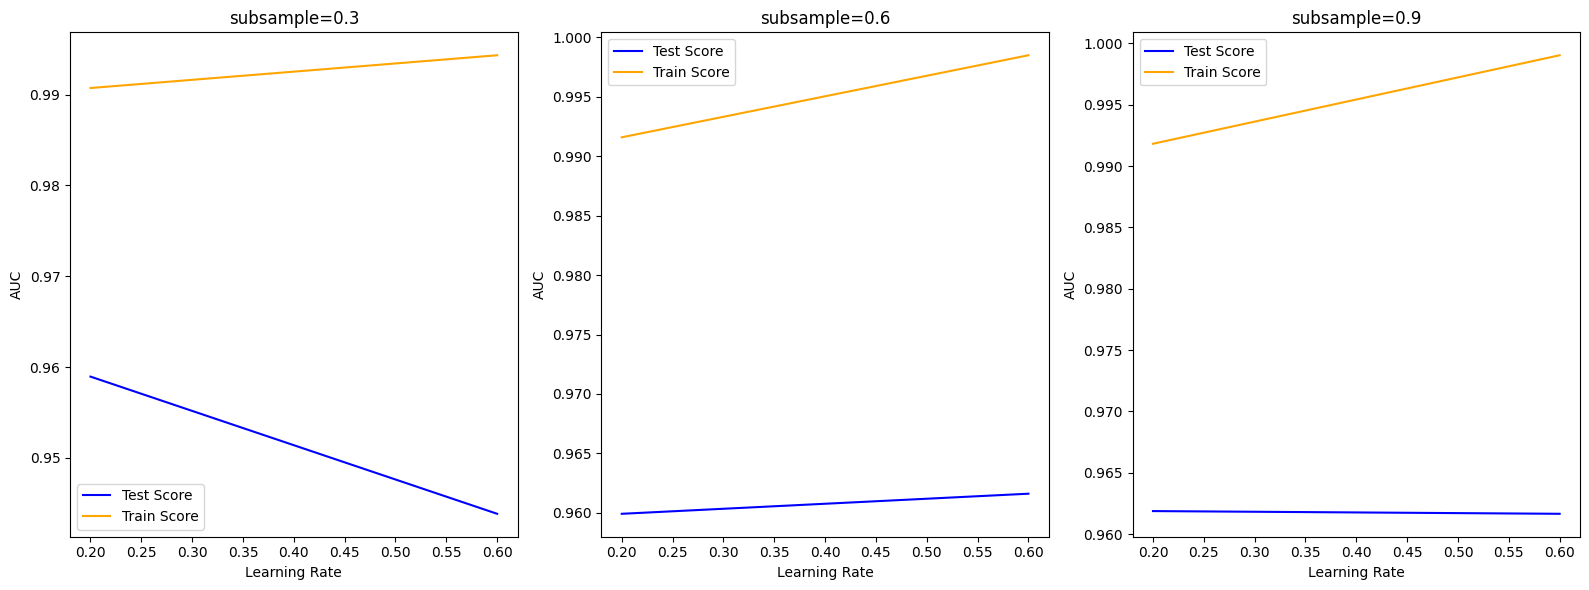

In [73]:
import matplotlib.pyplot as plt

# Plotting AUC with hyperparameter combinations (learning_rate vs mean_test_score)
plt.figure(figsize=(16, 6))

# Loop through different values of 'subsample' from the param_grid
for n, subsample in enumerate(param_grid['subsample']):

    # Create a subplot for each subsample value
    plt.subplot(1, len(param_grid['subsample']), n + 1)

    # Filter the results to match the current subsample value
    df = cv_results[cv_results['param_subsample'] == subsample]

    # Plot mean_test_score vs. param_learning_rate and mean_train_score
    plt.plot(df["param_learning_rate"], df["mean_test_score"], label="Test Score", color='blue')
    plt.plot(df["param_learning_rate"], df["mean_train_score"], label="Train Score", color='orange')

    # Add labels and title
    plt.xlabel("Learning Rate")
    plt.ylabel("AUC")
    plt.title(f"subsample={subsample}")
    plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


The results show that a subsample size of 0.6 and learning_rate of about 0.2 seems optimal. Also, XGBoost has resulted in the highest ROC AUC obtained (across various hyperparameters).

#### Model with chosen hyperparameters

In [74]:
# Define the chosen hyperparameters and objective function
params = {
    'objective': 'binary:logistic',  # Outputs probabilities instead of labels
    'max_depth': 2,
    'n_estimators': 200,
    'learning_rate': 0.2,
    'subsample': 0.6,
    'random_state': 1
}

# Instantiate XGBClassifier with the defined parameters
XGB = XGBClassifier(**params)

# Fit the model on the training data
XGB.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [75]:
# Get prediction probabilities for the test data
y_pred = XGB.predict_proba(X_test)[:, 1]  # Taking probabilities for the positive class (1)

# Print top 10 prediction probabilities
print("Top 10 predicted probabilities:")
print(y_pred[:10])

Top 10 predicted probabilities:
[6.4131578e-05 2.3189727e-04 5.6411900e-05 6.4484059e-04 1.2324625e-03
 2.4872055e-05 1.2342188e-04 7.8195466e-05 2.3721402e-04 1.3497851e-03]


In [76]:
# Calculate the ROC AUC score
auc = roc_auc_score(y_test, y_pred)

# Print the AUC score
print(f"ROC AUC Score: {auc}")

ROC AUC Score: 0.9726807539185389


we got more ROC_AUC score after hyperparameter tunning

In [78]:
# Get feature importance
importance = XGB.get_booster().get_score(importance_type='weight')

importance

{'ip': 88.0,
 'app': 142.0,
 'device': 50.0,
 'os': 57.0,
 'channel': 109.0,
 'day_of_week': 14.0,
 'hour': 55.0,
 'ip_count': 39.0,
 'ip_day_hour': 8.0,
 'ip_hour_os': 3.0,
 'ip_hour_device': 8.0}

<Figure size 1200x800 with 0 Axes>

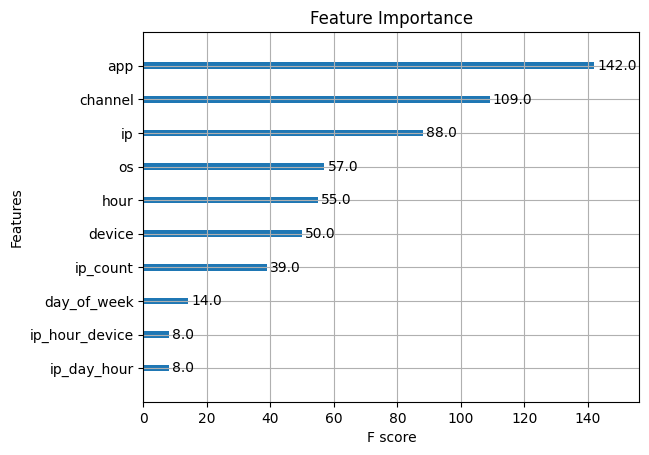

In [79]:
# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(XGB, importance_type='weight', max_num_features=10)  # Adjust max_num_features as needed
plt.title('Feature Importance')
plt.show()

# LightGBM

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks.

Since it is based on decision tree algorithms, it splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’.

In [80]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Instantiate LGBMClassifier with default hyperparameters and random_state=1
LGB = LGBMClassifier(random_state=1)

# Fit the model on the training data
LGB.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 182, number of negative: 79818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 888
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002275 -> initscore=-6.083498
[LightGBM] [Info] Start training from score -6.083498


LGBMClassifier(random_state=1)

In [81]:
# Use predict_proba to get probabilities
y_pred = LGB.predict_proba(X_test)[:, 1]  # Taking probabilities for the positive class (1)

# Print top 10 predicted probabilities
print("Top 10 predicted probabilities:")
print(y_pred[:10])

Top 10 predicted probabilities:
[8.48035204e-06 6.61500977e-06 5.73540850e-06 3.18121969e-06
 1.10611780e-05 2.37747348e-06 4.46062096e-06 8.55039405e-06
 1.55589370e-07 4.82988636e-06]


In [82]:
# Evaluate the predictions using ROC AUC score
roc = roc_auc_score(y_test, y_pred)

# Print AUC
print("ROC AUC score:", roc)

ROC AUC score: 0.8426799187059772


Now lets tune above model

In [83]:
# Instantiate LGBMClassifier with params
LGB = lgb.LGBMClassifier(learning_rate=0.2, max_depth=2, n_estimators=200, subsample=0.6, objective='binary', random_state=1)

# Fit model on training data
LGB.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 182, number of negative: 79818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 888
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002275 -> initscore=-6.083498
[LightGBM] [Info] Start training from score -6.083498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMClassifier(learning_rate=0.2, max_depth=2, n_estimators=200,
               objective='binary', random_state=1, subsample=0.6)

In [85]:
y_pred = LGB.predict_proba(X_test)[:, 1]  # Taking probabilities for the positive class (1)

# Evaluate predictions using roc_auc score
from sklearn.metrics import roc_auc_score
roc = roc_auc_score(y_test, y_pred)

# Print AUC score
print(f'ROC AUC Score: {roc}')

ROC AUC Score: 0.8560076839555667


nothing much improvment

# CatBOOST

CatBoost is a recently open-sourced machine learning algorithm from Yandex. It can easily integrate with deep learning frameworks like Google’s TensorFlow and Apple’s Core ML. It can work with diverse data types to help solve a wide range of problems that businesses face today. To top it up, it provides best-in-class accuracy.

In [87]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.1 MB/s eta 0:00:00


In [88]:
# Importing CatBoostClassifier
from catboost import CatBoostClassifier

# Instantiate CatBoostClassifier with default hyperparameters and random_state=1
Cat = CatBoostClassifier(random_state=1)

# Fit model on training data
Cat.fit(X_train, y_train)

Learning rate set to 0.06692
0:	learn: 0.5107569	total: 114ms	remaining: 1m 54s
1:	learn: 0.3698848	total: 147ms	remaining: 1m 13s
2:	learn: 0.2722563	total: 194ms	remaining: 1m 4s
3:	learn: 0.1980755	total: 219ms	remaining: 54.4s
4:	learn: 0.1496463	total: 245ms	remaining: 48.8s
5:	learn: 0.1161655	total: 278ms	remaining: 46.1s
6:	learn: 0.0904077	total: 353ms	remaining: 50s
7:	learn: 0.0718425	total: 414ms	remaining: 51.4s
8:	learn: 0.0587571	total: 448ms	remaining: 49.3s
9:	learn: 0.0471200	total: 474ms	remaining: 46.9s
10:	learn: 0.0391913	total: 512ms	remaining: 46s
11:	learn: 0.0337994	total: 540ms	remaining: 44.4s
12:	learn: 0.0296384	total: 569ms	remaining: 43.2s
13:	learn: 0.0249839	total: 596ms	remaining: 42s
14:	learn: 0.0214338	total: 627ms	remaining: 41.1s
15:	learn: 0.0193193	total: 668ms	remaining: 41.1s
16:	learn: 0.0177308	total: 697ms	remaining: 40.3s
17:	learn: 0.0160089	total: 726ms	remaining: 39.6s
18:	learn: 0.0146728	total: 823ms	remaining: 42.5s
19:	learn: 0.013

Lets Tune the model

In [89]:
# Define parameters for CatBoostClassifier
params = {
    'learning_rate': 0.2,
    'depth': 2,             # equivalent to max_depth
    'iterations': 200,      # equivalent to n_estimators
    'subsample': 0.6,
    'random_state': 1
}

# Instantiate CatBoostClassifier with params
Cat = CatBoostClassifier(**params)

# Fit the model on training data
Cat.fit(X_train, y_train)


0:	learn: 0.2613976	total: 17.8ms	remaining: 3.54s
1:	learn: 0.1107186	total: 33.2ms	remaining: 3.29s
2:	learn: 0.0567430	total: 47.2ms	remaining: 3.1s
3:	learn: 0.0347243	total: 61.6ms	remaining: 3.02s
4:	learn: 0.0247607	total: 75.3ms	remaining: 2.94s
5:	learn: 0.0184877	total: 92.6ms	remaining: 2.99s
6:	learn: 0.0158924	total: 106ms	remaining: 2.92s
7:	learn: 0.0144903	total: 122ms	remaining: 2.92s
8:	learn: 0.0133857	total: 161ms	remaining: 3.42s
9:	learn: 0.0126784	total: 189ms	remaining: 3.6s
10:	learn: 0.0124602	total: 227ms	remaining: 3.9s
11:	learn: 0.0120491	total: 241ms	remaining: 3.77s
12:	learn: 0.0117227	total: 254ms	remaining: 3.65s
13:	learn: 0.0115127	total: 269ms	remaining: 3.57s
14:	learn: 0.0113173	total: 282ms	remaining: 3.48s
15:	learn: 0.0111034	total: 312ms	remaining: 3.59s
16:	learn: 0.0109526	total: 330ms	remaining: 3.55s
17:	learn: 0.0108349	total: 347ms	remaining: 3.51s
18:	learn: 0.0107147	total: 360ms	remaining: 3.43s
19:	learn: 0.0105768	total: 374ms	rema

In [90]:
# Use predict_proba to get the probabilities (taking probabilities for the positive class)
y_pred = Cat.predict_proba(X_test)[:, 1]

# Evaluate predictions using roc_auc_score
roc = roc_auc_score(y_test, y_pred)

# Print the ROC AUC score
print(f"ROC AUC Score: {roc}")

ROC AUC Score: 0.9585400484423285
